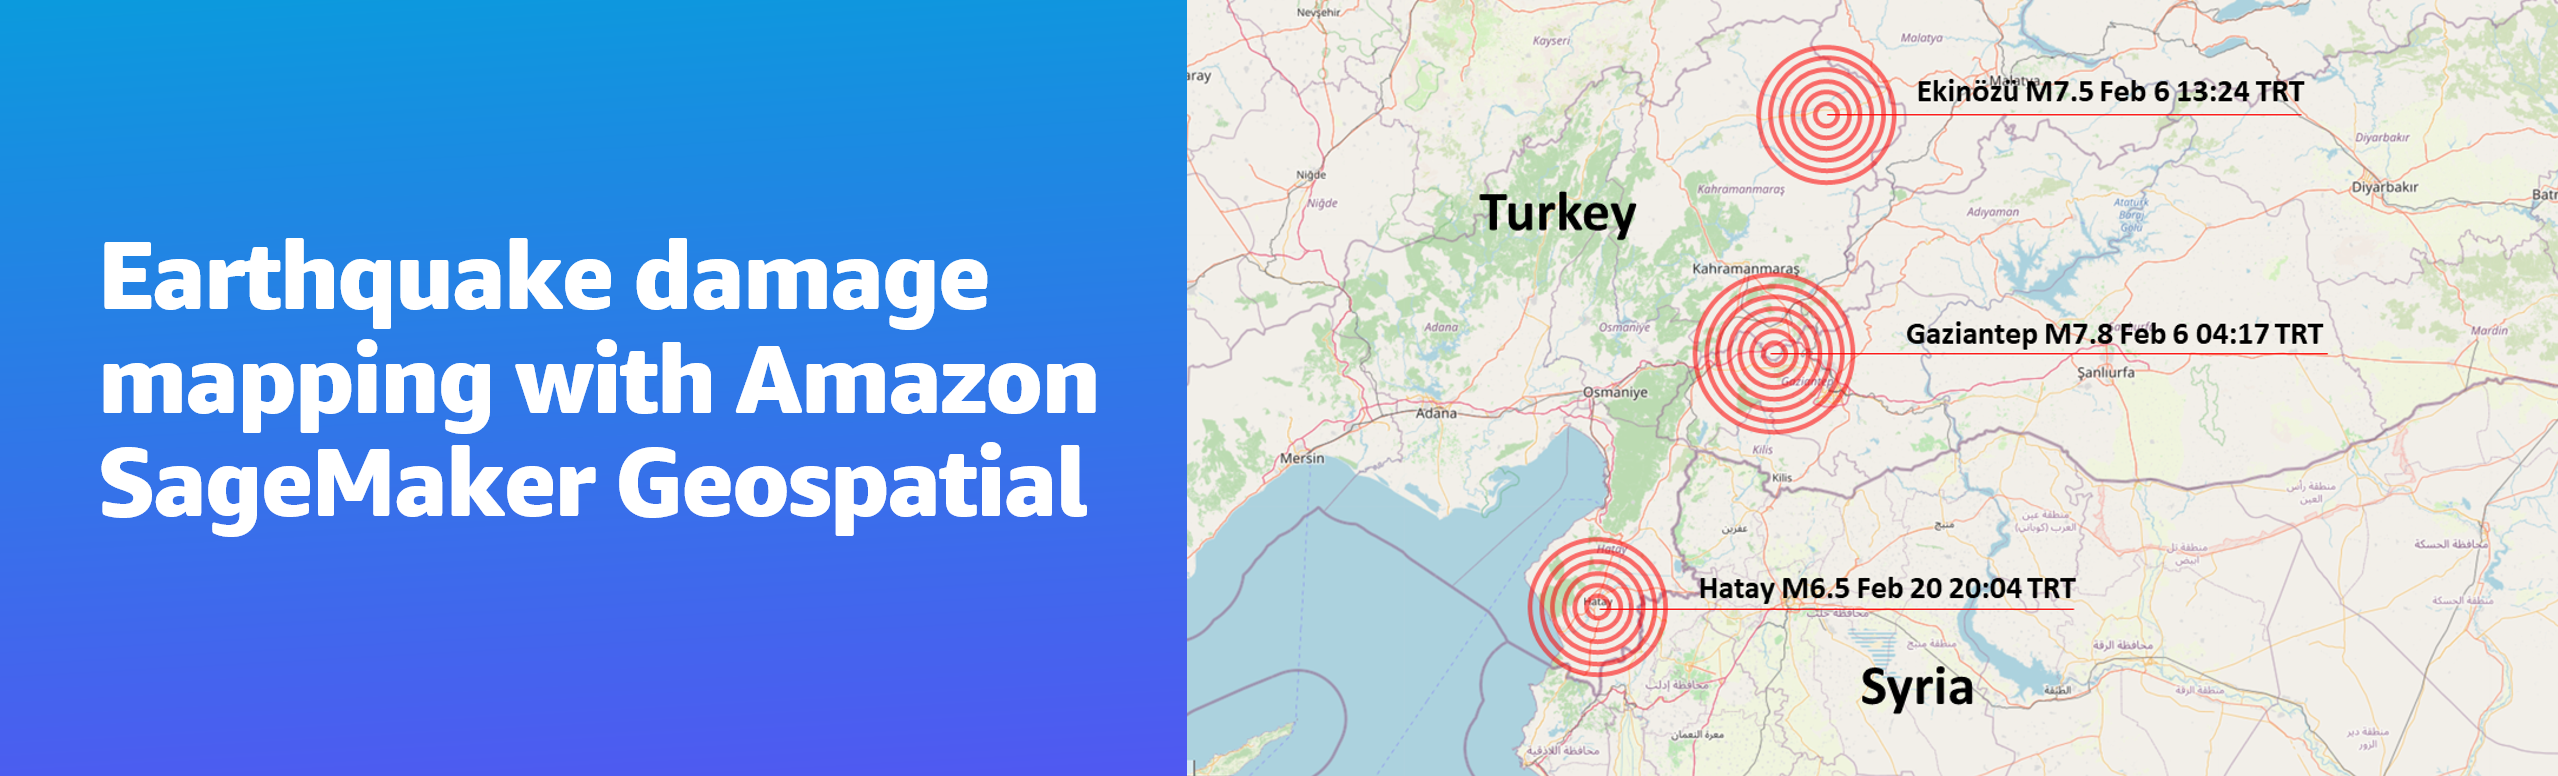

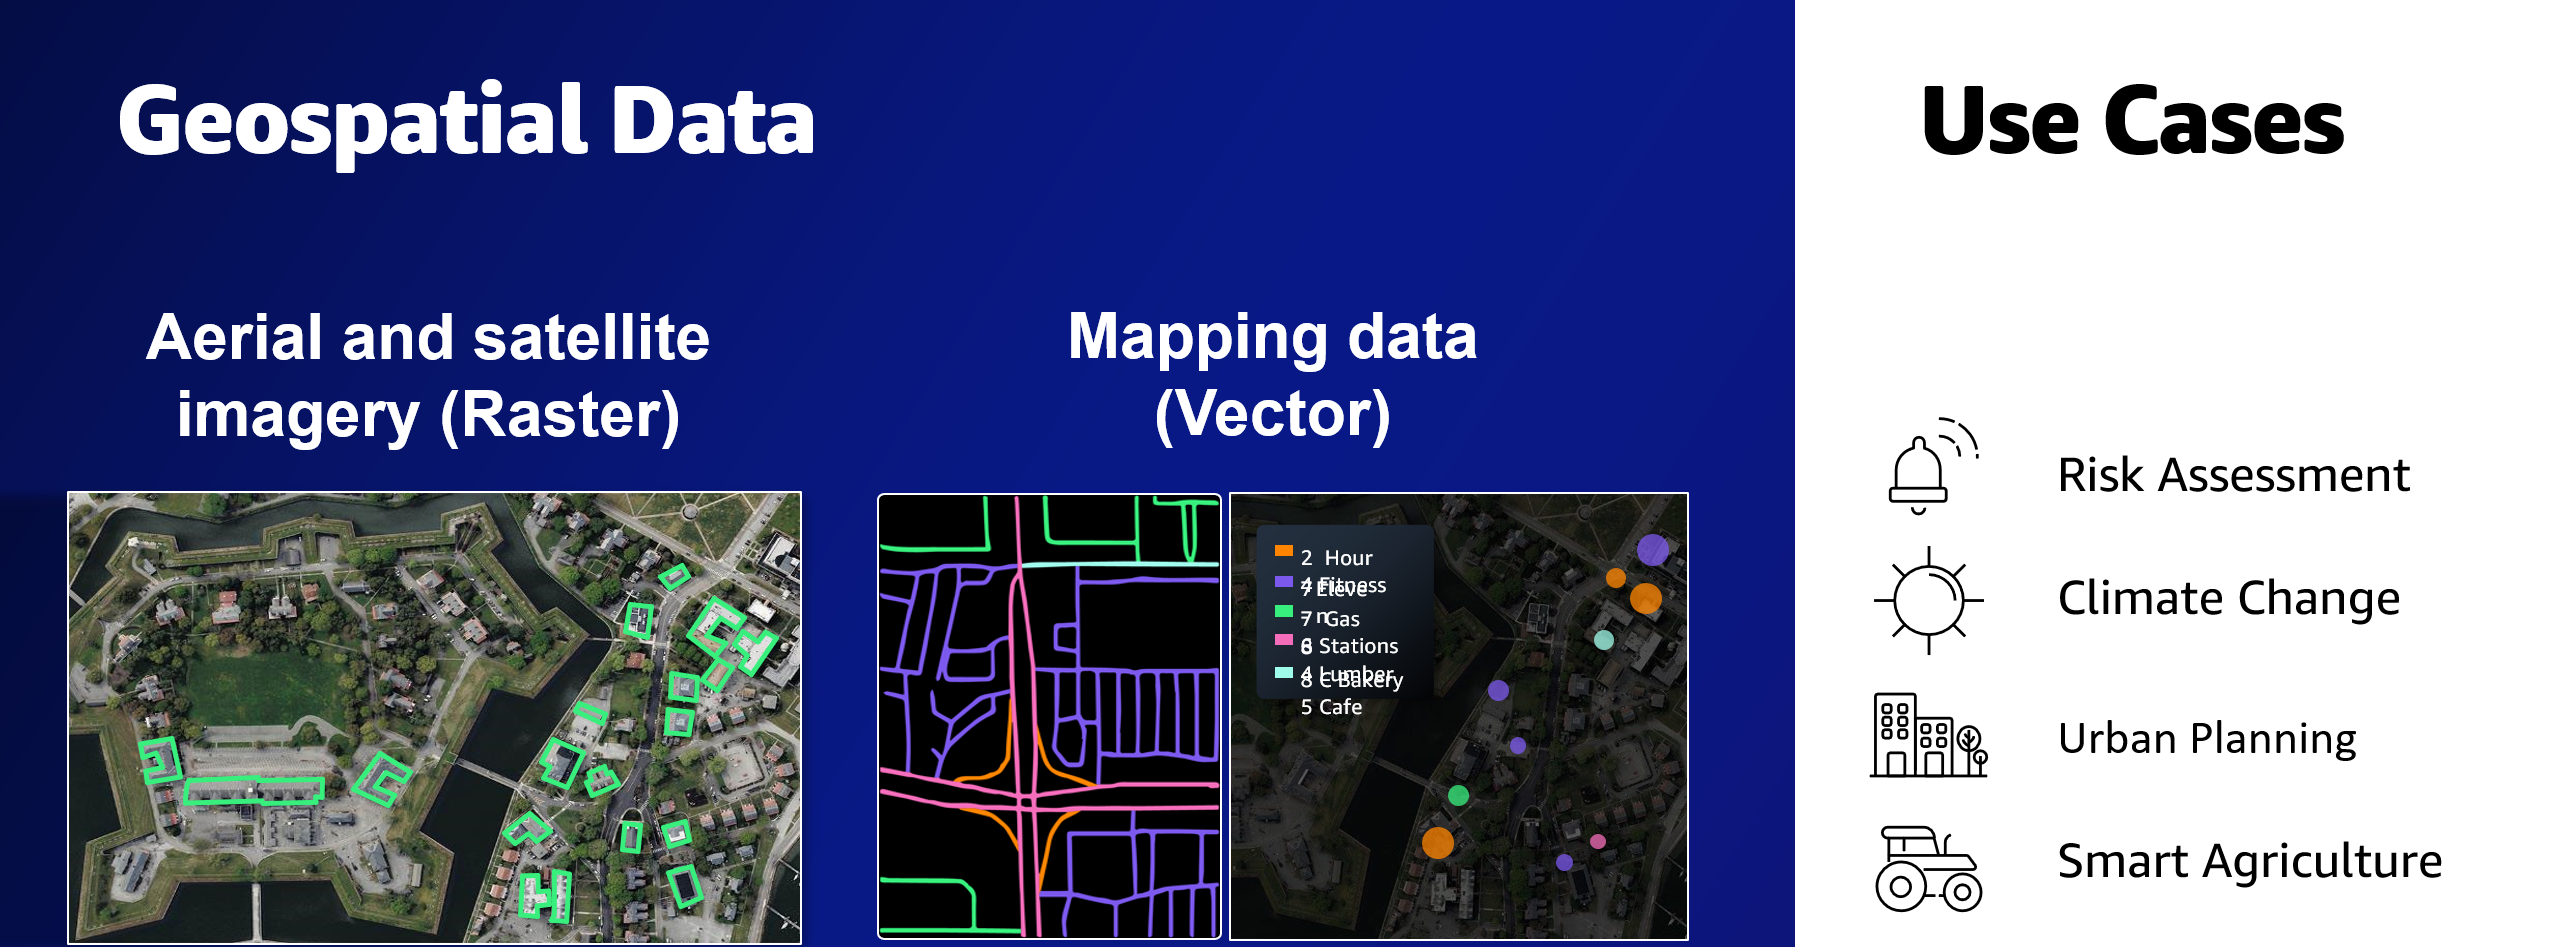

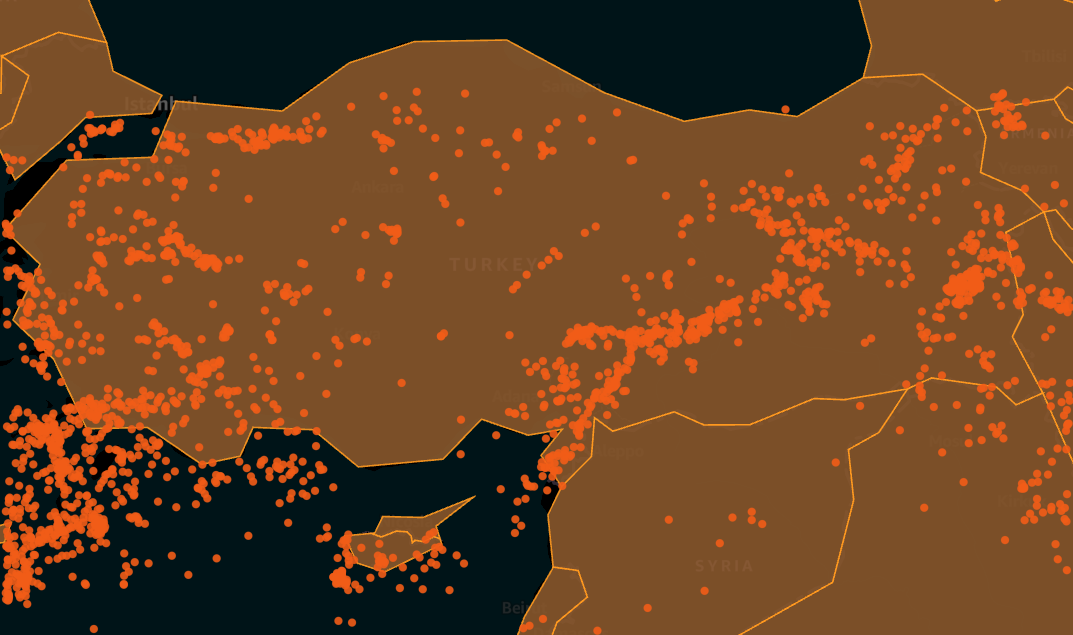

Amazon SageMaker geospatial capabilities make it easier for data scientists and machine learning (ML) engineers to build, train, and deploy ML models faster using geospatial data. Let's see it in action.

In [2]:
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
import leafmap.foliumap as leafmap
import boto3
import sagemaker
import sagemaker_geospatial_map

In [3]:
session = boto3.Session()
execution_role = sagemaker.get_execution_role()
sg_client = session.client(service_name="sagemaker-geospatial")

Use the SageMaker geospatial map to visualize all 4.5+ magnitude earthquakes in the Turkey region between 1950-2023.
<br>Data obtained from __[USGS](https://earthquake.usgs.gov/earthquakes/search/)__

In [91]:
earthquakes_map = sagemaker_geospatial_map.create_map()
earthquakes_map.set_sagemaker_geospatial_client(sg_client)

In [95]:
earthquakes_map.render()

SyncWidgetMap(style={'height': '100%', 'width': '100%'}, urls={'staticAssetUrlBase': 'https://d22zkd5i0te8j2.c…

In [ ]:
from scripts.turkey_earthquakes import visualize_turkey_earthquakes
visualize_turkey_earthquakes(earthquakes_map)

## Data Collection
You can access data from a catalog of geospatial data providers. Currently, the data collections available include:
USGS Landsat and Sentinel-2.<br>
First, we List available data collections as part of the SageMaker Geospacial capabilities

In [39]:
# List available data collections
supported_raster_data_collection = sg_client.list_raster_data_collections()
pd.DataFrame.from_dict(supported_raster_data_collection['RasterDataCollectionSummaries']) \
    [['Name', 'Arn', 'Description']].style.set_properties(**{'text-align': 'left'})

## Area of Interest (AOI)
Next, we define an erea of interest (AOI) - a polygon with coordinates, as well as the required time range.

In [40]:
# Time Range - the earthquake happened on 6-Feb-2023.
startTime = "2023-01-27T00:00:00Z"
startTimeEOD = "2023-01-27T23:59:59Z"
endTimeSOD = "2023-02-09T00:00:00Z"
endTime = "2023-02-09T23:59:59Z"

In [41]:
# Define the center point - 37.226°N 37.014°E
center_point = Point(37.226, 37.014)

# Calculate square corners coordinates
side_length = 2
half_side = side_length / 2
xmin = center_point.x - half_side
xmax = center_point.x + half_side
ymin = center_point.y - half_side
ymax = center_point.y + half_side

# Area of Interest
aoi = Polygon([Point(xmin,ymin), Point(xmin, ymax), Point(xmax,ymax),  Point(xmax,ymin)])
print(aoi)

POLYGON ((36.226 36.014, 36.226 38.014, 38.226 38.014, 38.226 36.014, 36.226 36.014))


In [42]:
# Save to file
s = gpd.GeoSeries(aoi.boundary, crs="EPSG:4326")
polygon_gdf = gpd.GeoDataFrame(index=[0],crs='epsg:4326', geometry=s)
polygon_gdf.to_file(filename='output/polygon.geojson', driver='GeoJSON')

In [43]:
# Visualize Area of Interest
m = leafmap.Map(center=[36.844461, 37.386475], zoom=8)
m.add_geojson("output/polygon.geojson", layer_name="Footprints")
m

## Search for avaialble images
Calling the search_raster_data_collection function to check how many images we have for the selected area and time range

In [136]:
# Query Data Collection
# Call search_raster_data_collection() to obtain images in the required area and time range.
sentinel2_arn = "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8"
search_rdc_args = {
    "Arn": sentinel2_arn,
    "RasterDataCollectionQuery": {
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {
                "PolygonGeometry": {
                    "Coordinates": [
                        [
                            [xmin,ymin],
                            [xmin,ymax],
                            [xmax,ymax],
                            [xmax,ymin],
                            [xmin,ymin]
                        ]
                    ]
                }
            }
        },
        "TimeRangeFilter": {
            "StartTime": startTime,
            "EndTime": endTime,
        },
        "PropertyFilters": {
            "Properties": [{"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": 10}}}],
            "LogicalOperator": "AND",
        },
        #"BandFilter": ["visual"],
    },
}

# Identify relevant iamge URLs using search_raster_data_collection()
tci_urls = []
tci_thumbnails = []
while search_rdc_args.get("NextToken", True):
    search_result = sg_client.search_raster_data_collection(**search_rdc_args)
    for item in search_result["Items"]:
        tci_url = item["Assets"]["visual"]["Href"]
        print(tci_url)
        tci_urls.append(tci_url)
        tci_thumbnails.append(item["Assets"]["thumbnail"]["Href"])

    search_rdc_args["NextToken"] = search_result.get("NextToken")


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/S/YE/2023/2/S2A_36SYE_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/BV/2023/2/S2A_37SBV_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/CV/2023/2/S2A_37SCV_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/S/YF/2023/2/S2A_36SYF_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DV/2023/2/S2A_37SDV_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/BA/2023/2/S2A_37SBA_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/CA/2023/2/S2A_37SCA_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2023/2/S2A_37SDA_20230209_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentine

In [161]:
len(tci_urls) # home many images have we got?

21

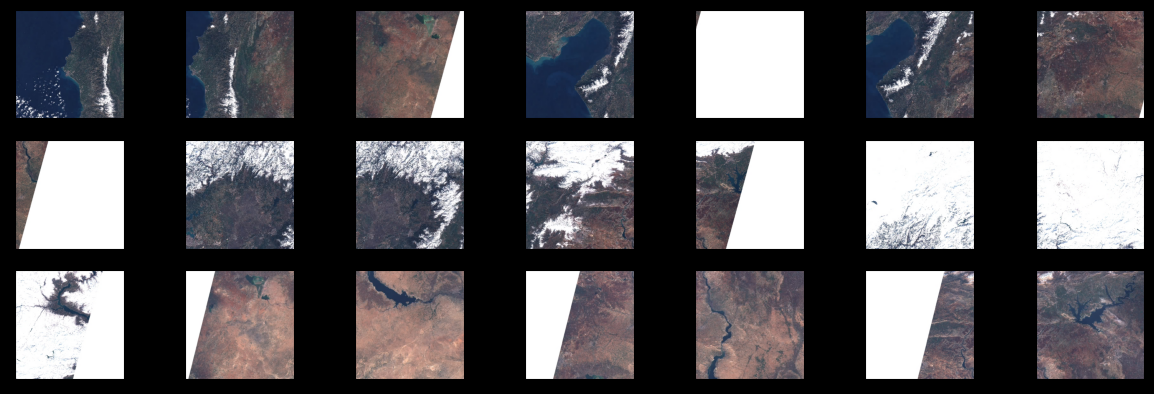

In [188]:
# Sanity-print image thumbnails
import urllib
import matplotlib.pyplot as plt
%matplotlib inline
fig, axarr = plt.subplots(3,7)
plt.setp(axarr, xticks=[], yticks=[])
fig.set_facecolor('black')
fig.set_figwidth(15)
for i, thumbnail in enumerate(tci_thumbnails):
	f = urllib.request.urlopen(thumbnail)
	a = plt.imread(f, "jpg")
	col = i % 7
	row = i // 7
	axarr[row,col].imshow(a)

## Cloud Removal Job

Using an Earth Observation job (EOJ), you can acquire, transform, and visualize geospatial data to make predictions. You can choose an operation based on your use case from a wide range of operations and models, including: Cloud Masking, Cloud Removal, Resampling, Geomosaic, Land Cover Segmentation.

In [46]:
# Print job status helper function
def printJobStatus(job_arn):
    job_details = sg_client.get_earth_observation_job(Arn=job_arn)
    {print(k,": ",v) for k, v in job_details.items() if k in ["Arn", "Status", "DurationInSeconds"]}

In [47]:
# Perform Cloud Removal
eoj_input_config = {
    "RasterDataCollectionQuery": {
        "RasterDataCollectionArn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {
                "PolygonGeometry": {
                    "Coordinates": [
                        [
                            [xmin,ymin],
                            [xmin,ymax],
                            [xmax,ymax],
                            [xmax,ymin],
                            [xmin,ymin]
                        ]
                    ]
                }
            }
        },
        "TimeRangeFilter": {
            "StartTime": endTimeSOD,
            "EndTime": endTime,
        },
        "PropertyFilters": {
            "Properties": [{"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": 10}}}],
            "LogicalOperator": "AND",
        },
    }
}

eoj_config = {
        "CloudRemovalConfig": {
            "AlgorithmName": "INTERPOLATION",
            "InterpolationValue": "-9999",
            "TargetBands": ["red", "green", "blue", "nir", "swir16"],
        },
}

eoj_response = sg_client.start_earth_observation_job(
    Name="Turkey-earthquake-cloud-removal",
    InputConfig=eoj_input_config,
    JobConfig=eoj_config,
    ExecutionRoleArn=execution_role,
)

In [52]:
eoj_arn_cloud_removal = eoj_response["Arn"]
printJobStatus(eoj_arn_cloud_removal)

Arn :  arn:aws:sagemaker-geospatial:us-west-2:261416220256:earth-observation-job/cnijd2dfbcyb
DurationInSeconds :  1946
Status :  COMPLETED


## Create before/after mosaics

In [53]:
# Create Mosaic on original images (endTime)
# Before cloud removal
eoj_config_mosaic = {"GeoMosaicConfig": {"AlgorithmName": "NEAR"}}

eoj_response_mosaic_before = sg_client.start_earth_observation_job(
    Name="Turkey-earthquake-mosaic-enddate",
    InputConfig=eoj_input_config,
    JobConfig=eoj_config_mosaic,
    ExecutionRoleArn=execution_role,
)

In [62]:
eoj_arn_mosaic_before = eoj_response_mosaic_before["Arn"]
printJobStatus(eoj_arn_mosaic_before)

Arn :  arn:aws:sagemaker-geospatial:us-west-2:261416220256:earth-observation-job/dk7chy6p73fn
DurationInSeconds :  1406
Status :  COMPLETED


In [57]:
# Create Mosaic on transformed images (endTime)
# After cloud removal
eoj_response_mosaic_after = sg_client.start_earth_observation_job(
    Name="Turkey-earthquake-mosaic-enddate-clouds-removed",
    InputConfig = {"PreviousEarthObservationJobArn": eoj_arn_cloud_removal},
    JobConfig=eoj_config_mosaic,
    ExecutionRoleArn=execution_role,
)

In [63]:
printJobStatus(eoj_response_mosaic_after["Arn"])

Arn :  arn:aws:sagemaker-geospatial:us-west-2:261416220256:earth-observation-job/4druuma3wfui
DurationInSeconds :  1347
Status :  COMPLETED


 ## Visualize Cloud Removal Results
 
Using the visualization functionalities provided by Amazon SageMaker geospatial you can visualize geospatial data, the inputs to your earth observation jobs as well as the outputs exported from your Amazon S3 bucket. The visualization tool is powered by Foursquare Studio.

In [64]:
time_range_filter = {
    "start_date": endTimeSOD,
    "end_date": endTime,
}

In [97]:
# Visualize EOJ inputs and outputs
map = sagemaker_geospatial_map.create_map({"is_raster": True})
map.set_sagemaker_geospatial_client(sg_client)

In [128]:
map.render()

SyncWidgetMap(raster={'stacSearchUrl': AnyHttpUrl('https://domain-name/raster', )}, style={'height': '100%', '…

In [125]:
# Visualize AOI
#eoj_arn_mosaic_before
aoi_layer = map.visualize_eoj_aoi(Arn=eoj_arn_mosaic_before, config={"label": "Area of Interest"})

In [126]:
from scripts.turkey_earthquakes import add_earthquakes
add_earthquakes(map)

In [127]:
# Visualize input
input_layer = map.visualize_eoj_input(
    Arn = eoj_arn_mosaic_before,
    config = {"label": "Input"},
    time_range_filter = time_range_filter
)

In [75]:
# Visualize output
output_layer = map.visualize_eoj_output(
    Arn = eoj_arn_cloud_removal,
    config = {"label": "output", "preset":"trueColor"},
    time_range_filter = time_range_filter
)

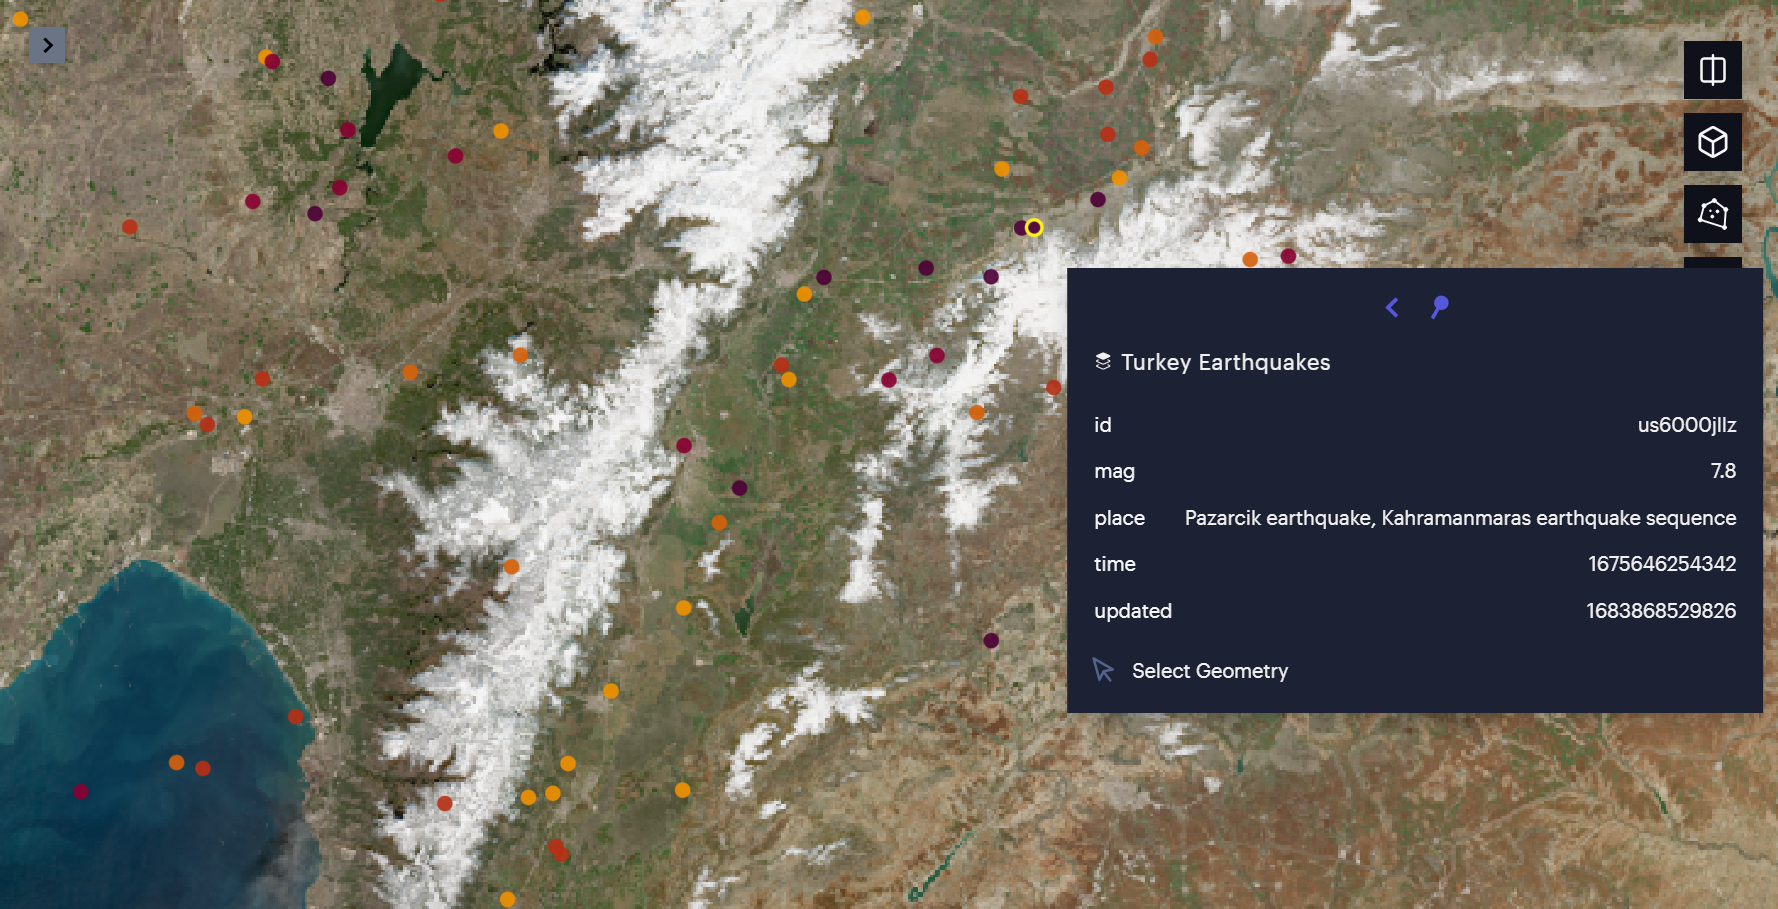